 # Libraries Guide
* torch, nn, optim - used to define and train the (fuzzy) neural networks in PyTorch
* numpy - numerical operations (arrays, math, etc.)
* matplotlib - for visualizing results (loss curves, predictions)
* sklearn - dataset loading, preprocessing, and splitting

#### Note: 
Some scripts and functions are intentionally repeated to make it easier to track which ones are used in each exercise.

# ANFIS Regression Problem: Dataset 1

In [305]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas


In [306]:
# CHOOSE DATASET

# Binary classification dataset
data = datasets.load_diabetes(as_frame=True)

# Regression dataset
#data = datasets.fetch_openml(name="diabetes",version=1, as_frame=True) 

X = data.data.values     # Feature Assignement to variable X: (442 samples, 10 features)
y = data.target.values   # target assignment to varible Y: (442 samples, 1 target)

print(X.shape)    # Check dimensions X: should be (442, 10)
print(y.shape)    # Check dimensions Y: should be (442, ) - 1D array in numpy 

(442, 10)
(442,)


In [307]:
# Visualising first 5 rows of Dataset 1
data.data.head(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


#### Coment
Looks like the dataset (scikit-learn built in) is standardized internally, explaining the small values instead of raw expectable medical values

In [308]:
#train test spliting
test_size=0.2 # 20 % of data will be reserved for testing (or dev more apropriatly),and 80 % for training 
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

# Note: for comparisons is important to mantain both the train/test split and the seed (random_state) equal across model

In [309]:
# Standardize features
# Note: standardization ensures that all input variables contribute equally 
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

# Fuzzy C-Means Clutering 
#### Arguments:
* Xexp_T - dataset (features x samples)
* n_clusters - number of clusters (fuzzy rules)
* m - fuzziness parameter
* error - stopping criterion (tolerance for convergence)
* maxiter - maximum number of iterations
* init=None - centers initialized randomly

#### Returns:
* centers - coordinates of cluster centers (one per rule)
* u - final fuzzy membership matrix (shape: n_clusters x samples)
* u0 - initial membership matrix
* d - final Euclidean distances between samples and centers
* jm - objective function history
* p - number of iterations run
* fpc - fuzzy partition coefficient (validity measure of clustering)
---
### Fuzzy C-Means (FCM) Formulas

**1. Membership degree update**

$$
u_{ij} = \frac{1}{\sum\limits_{k=1}^{c} \left( \frac{\|x_i - v_j\|}{\|x_i - v_k\|} \right)^{\frac{2}{m-1}} }
$$

where:  
- \( u_{ij} \in [0,1] \) = degree of membership of point \(x_i\) in cluster \(j\)  
- \( c \) = number of clusters  
- \( m > 1 \) = fuzziness exponent (controls how “soft” memberships are)  
- \( v_j \) = center of cluster \(j\)  
- \( \|\cdot\| \) = Euclidean distance  



**2. Cluster center update**

$$
v_j = \frac{\sum\limits_{i=1}^{N} \big(u_{ij}\big)^m \, x_i}{\sum\limits_{i=1}^{N} \big(u_{ij}\big)^m}
$$

where:  
- \( N \) = number of data points  
- \( (u_{ij})^m \) = membership degree raised to fuzziness \(m\), used as weight  



**3. Objective function**

$$
J_m = \sum_{i=1}^{N} \sum_{j=1}^{c} \big(u_{ij}\big)^m \, \|x_i - v_j\|^2
$$

FCM minimizes this objective function iteratively by updating memberships and cluster centers until convergence.

In [310]:
## Number of clusters 
n_clusters = 2  # Each cluster corresponds to one fuzzy rule in the TSK model
m = 2 # Controls how "soft" the clustering is:
# - Larger m more overlap bettwen clusters 
# - lower m clustering is harder (memberships closer to 0 or 1)

## Concatenate target for clustering
# This way, the clustering considers both input space (Xtr) and output (ytr)
# This helps place cluster centers in regions that capture input-output relations
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T  # each row is one feature plus target

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [311]:
centers.shape # Check the shape of the cluster centers matrix

(2, 11)

In [312]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m (fuzziness parameter)
    u_j = u[j, :] ** m 
    # weighted variance for each feature (ensures points with higher membership contribute more
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j) #(Xexp - centers[j])**2 squared distance for each sample to cluster center 
    sigma_j = np.sqrt(var_j)  # standard deviation
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Fuzzy partition coefficient (FPC): 0.8556187636174124


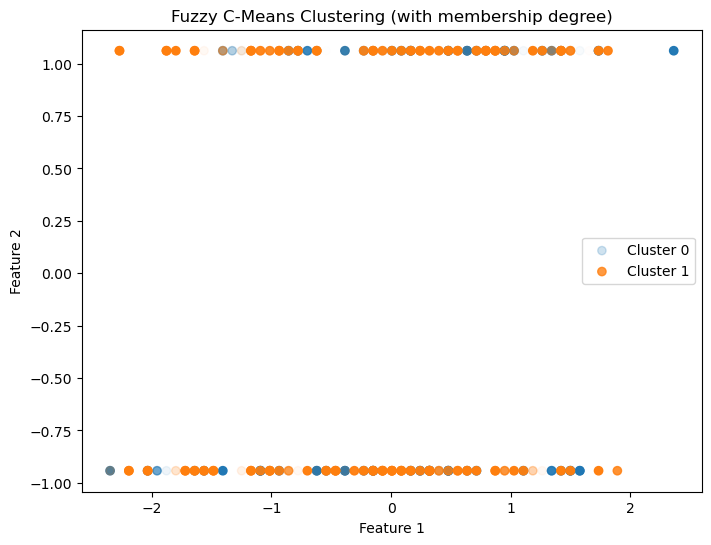

In [313]:
# === CLUSTER VISUALISATION === 

# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0) # Each sample is assigned to the cluster where it has the highest membership degree

# Note: FPC ∈ [0, 1], where:
#   - Values closer to 1 indicate well-defined, distinct clusters
#   - Values closer to 0 indicate poor clustering 
print("Fuzzy partition coefficient (FPC):", fpc)


# --- Plot first two features with fuzzy membership ---
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    # alpha = u[j,:] → transparency reflects membership degree:
    #   - strong membership:  darker color
    #   - weak membership : lighter color
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

#### Plot 1: Results Comment
* (In dataset 1) Feature 2 corresponds to ‘sex’, a binary variable (male/female). Because it only takes two distinct values, fuzzy clustering naturally produces two well-separated membership groups along this dimension, resulting in very crisp rule assignments compared to continuous features (such as age).

FPC ≈ 0.85561 (with c=2)

* Samples tend to have high membership in one cluster and low in the other.
* Clusters are well-separated, fuzzy overlap is limited.
* The rules built from these clusters will be more interpretable, since each rule covers a clearer region of the input space

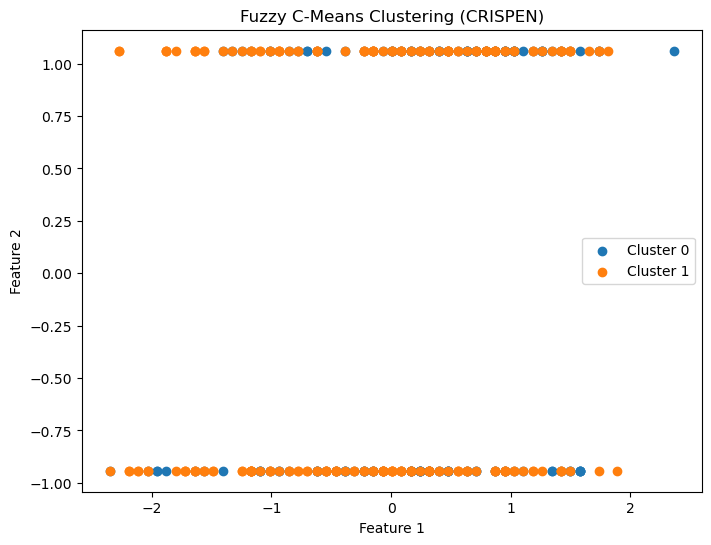

In [314]:
# Plot first two features with cluster assignments (crispened version)
plt.figure(figsize=(8,6))

for j in range(n_clusters):
    # Scatter plot of samples assigned to cluster j (hard clustering).
    # Unlike the previous fuzzy plot, here we ignore membership degrees (alpha),
    # and simply color points by their most likely cluster.
    plt.scatter(
        Xexp[cluster_labels == j, 0],  # Feature 1 
        Xexp[cluster_labels == j, 1],  # Feature 2 
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

#### Plot 2: Results Comment
As mentioned before, unlike the previous fuzzy plot, here we ignore membership degrees (alpha), and simply color points by their most likely cluster, explaining the absence of color gradients.

# Gaussian Membership function
#### Inputs:
   - x: input values (vector)
   - mu: mean (center of the Gaussian, from clustering)
   - sigma: standard deviation (spread of the Gaussian, from clustering)
#### Output:
   - degree of membership ∈ [0, 1]

$$
\mu(x) = \exp\left(-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2\right)
$$


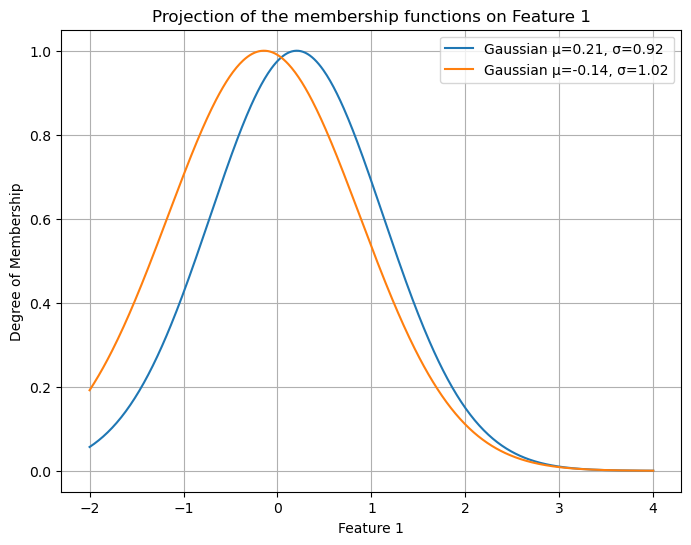

In [315]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

# Generate a range of values for Feature 1 (x-axis of the plot).
# This will let us visualize the Gaussian curves for that feature
lin=np.linspace(-2, 4, 500)

plt.figure(figsize=(8,6))


y_aux=[]
for j in range(n_clusters):
    # Compute the Gaussian curve for cluster j on Feature 1.
    # centers[j,0] = mean of cluster j for Feature 1
    # sigmas[j,0] = spread of cluster j for Feature 1
    y_aux.append(gaussian(lin, centers[j,0], sigmas[j,0]))

# Plot Gaussian membership 
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,0],2)}, σ={np.round(sigmas[j,0],2)}")

plt.title("Projection of the membership functions on Feature 1")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

#### Plot 2: Results Comment
On Feature 1, the two cluster centers were μ ≈ 0.21 and μ ≈ –0.14, with spreads close to one. Since the distance between the means (≈0.35) is much smaller than the standard deviation, the two Gaussian membership functions overlap substantially. This indicates that Feature 1, by itself, does not provide strong discriminative power for separating the fuzzy rules.

In [316]:
# ---------------------------
# Gaussian Membership Function (Antecedents of fuzzy rules)
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        # Each Gaussian MF is defined by its center (μ) and spread (σ).
        # Both are learnable parameters initialized from clustering.
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))

        # Flag for aggregation type:
        # If True: use probabilistic (L2 norm) aggregation
        # If False: use max-distance (equivalent to fuzzy "min" operator)
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting (Broadcasting automatically expands tensors with singleton dimensions (size 1) 
        #so their shapes are compatible for mathematical operations)
        # x: (batch, n_inputs) → (batch, 1, n_inputs)
        # centers: (n_rules, n_inputs) -> (1, n_rules, n_inputs)
        # sigmas: (n_rules, n_inputs) -> (1, n_rules, n_inputs)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation of distances across input dimensions
        if self.agg_prob:
            # Probabilistic aggregation: smoother intersection across features
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)

        # Final Gaussian membership degree (∈ [0,1])
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)    # Shape: (n_inputs+1, n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Step 1: Compute rule firing strengths via Gaussian MFs
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Step 2: Normalize firing strengths so they sum to 1 for each sample
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Step 3: Compute rule consequents (linear functions of inputs)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias 

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)

        # Step 4: Weighted sum of rule outputs by normalized firing strengths
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        # Return:
        # - output: final prediction
        # - norm_fs: normalized rule activations
        # - rule_outputs: per-rule consequent output
        return output, norm_fs, rule_outputs


In [317]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    # Disable gradient tracking: LS solution is closed-form, no need for backprop
    with torch.no_grad():
        _, norm_fs, _ = model(X) # norm_fs: (n_samples, n_rules)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)

        # Build the design matrix Φ:
        # For each sample, compute input × normalized firing strength per rule
        # einsum: "br" (samples × rules) × "bi" (samples × inputs) → "bri" (samples × rules × inputs)
        # Reshape → (n_samples, (n_rules * (n_inputs+1)))
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        # Using PyTorch's built-in lstsq solver
        theta= torch.linalg.lstsq(Phi, y).solution
    
        # Reshape theta into (n_inputs+1, n_rules) and assign to model parameters
        model.consequents.data = theta.reshape(model.consequents.shape)


In [318]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    # Define optimizer: Adam
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Define loss function: Mean Squared Error (MSE) for regression
    criterion = nn.MSELoss()

    # Training Loop
    for _ in range(epochs):
        # Reset accumulated gradients from previous iteration
        optimizer.zero_grad()

        # Forward propagation: predict outputs from the model
        y_pred, _, _ = model(X)

         # Compute loss: mean squared error between predictions and targets
        loss = criterion(y_pred, y)
        print(loss) # to monitor convergence

        # Backward pass: compute gradients of loss of all trainable parameter
        loss.backward()

        # Parameter update: optimizer adjusts centers, sigmas, consequents
        optimizer.step()


In [319]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    """
    Trains an Adaptive Neuro-Fuzzy Inference System (ANFIS) using the hybrid approach:
    - Alternates between Gradient Descent (GD) and Least Squares (LS)
    - GD updates the antecedents (membership function parameters)
    - LS updates the consequents (linear coefficients of fuzzy rules)

    Parameters:
    -----------
    model : ANFIS model instance
    X : torch.Tensor
        Input features.
    y : torch.Tensor
        Target values.
    max_iters : int (default=10)
        Number of hybrid training cycles. 
        Each cycle = one round of GD + LS.
         Larger values → more refinement but higher runtime.
    gd_epochs : int (default=20)
        Number of gradient descent epochs per cycle (for antecedents).
         If max_iters=10 and gd_epochs=20 → total GD epochs = 10*20 = 200.
    lr : float (default=1e-3)
        Learning rate for gradient descent updates.
         Higher values = faster learning but risk of instability (going in the right direction, but the huge steps pass the objective easily) .
    """

    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

In [320]:
# ---------------------------
# Alternative Hybrid Training (LS+ gradient descent on all)
# ---------------------------
def train_hybrid(model, X, y, epochs=100, lr=1e-3):
    """
    Alternative hybrid training strategy:
    - First fits the consequents with Least Squares (fast, exact solution for linear part).
    - Then applies Gradient Descent to fine-tune *all* parameters (antecedents + consequents).

    Parameters:
    -----------
    model : ANFIS model instance
    X : torch.Tensor
        Input features.
    y : torch.Tensor
        Target values.
    epochs : int (default=100)
        Number of GD iterations for joint fine-tuning.
    lr : float (default=1e-4)
        Learning rate for GD. Typically smaller than in the classic hybrid,
        since all parameters are moving together and training is less stable.
    """
    
    # Step 1: LS for consequents
    train_ls(model, X, y)
    # Step 2: GD fine-tuning
    train_gd(model, X, y, epochs=epochs, lr=lr)


In [321]:
# Build model
model = TSK(n_inputs=Xtr.shape[1],   # number of input features 
            n_rules=n_clusters,      # number of fuzzy rules (from clustering) 
            centers=centers[:,:-1],  # antecedent centers (esclude last col = target)
            sigmas=sigmas[:,:-1]     # antecedent spreads (exclude target dimension)
)

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)


In [322]:
# Training with LS:
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1)) # reshape target y to match tje expected matrix dimensions


tensor(2683.3860, grad_fn=<MseLossBackward0>)
tensor(2682.0847, grad_fn=<MseLossBackward0>)
tensor(2680.8650, grad_fn=<MseLossBackward0>)
tensor(2679.6689, grad_fn=<MseLossBackward0>)
tensor(2678.5107, grad_fn=<MseLossBackward0>)
tensor(2677.3970, grad_fn=<MseLossBackward0>)
tensor(2676.3137, grad_fn=<MseLossBackward0>)
tensor(2675.2290, grad_fn=<MseLossBackward0>)
tensor(2674.1230, grad_fn=<MseLossBackward0>)
tensor(2673.0249, grad_fn=<MseLossBackward0>)
tensor(2671.9297, grad_fn=<MseLossBackward0>)
tensor(2670.8411, grad_fn=<MseLossBackward0>)
tensor(2669.7651, grad_fn=<MseLossBackward0>)
tensor(2668.6753, grad_fn=<MseLossBackward0>)
tensor(2667.5894, grad_fn=<MseLossBackward0>)
tensor(2666.4998, grad_fn=<MseLossBackward0>)
tensor(2665.4185, grad_fn=<MseLossBackward0>)
tensor(2664.3625, grad_fn=<MseLossBackward0>)
tensor(2663.3154, grad_fn=<MseLossBackward0>)
tensor(2662.2722, grad_fn=<MseLossBackward0>)
tensor(2658.7769, grad_fn=<MseLossBackward0>)
tensor(2657.5015, grad_fn=<MseLoss

In [323]:
# ----------------------
# Model Evaluation
#-----------------------

y_pred, _, _=model(Xte)
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

MSE:2658.316162109375


### ANFIS Regression Result Coments

##### Effect of number of clusters / m parameter

* Increasing clusters or adjusting fuzzification parameter m changes model flexibility, but results show variability in MSE due to stochastic training.
* Even for the same parameter settings, MSE is not identical between runs — reflecting the randomness in initialization and GD optimization.
* General trend: more clusters can reduce bias (fit more detail), but may increase variance and instability.

##### Effect of learning rate (lr), max_iters, gd_epochs

In theory, higher max_iters and gd_epochs should improve convergence, and lr controls step size.
In practice, because MSE fluctuates between runs, the improvements are not always consistent.

Observed tendency:
* Small learning rates (e.g. 1e-5) → slower convergence, sometimes underfitting (but that can be safely compensated by the number of epochs).
* Larger learning rates (e.g. 1e-2) → risk of unstable training (bigger steps in the "right" direction issue), higher variance in MSE.
* Moderate values (1e-3) generally gave the most stable performance.

# Neural Networks Regression Problem: Dataset 1

In [324]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas

In [325]:
# CHOOSE DATASET

# Binary classification dataset
data = datasets.load_diabetes(as_frame=True)

# Regression dataset
#data = datasets.fetch_openml(name="diabetes",version=1, as_frame=True) 

X = data.data.values     # Feature Assignement to variable X: (442 samples, 10 features)
y = data.target.values   # target assignment to varible Y: (442 samples, 1 target)

print(X.shape)    # Check dimensions X: should be (442, 10)
print(y.shape)    # Check dimensions Y: should be (442, ) - 1D array in numpy 

(442, 10)
(442,)


In [326]:
# Visualising first 5 rows of Dataset 1
data.data.head(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


#### Coment
Looks like the dataset (scikit-learn built in) is standardized internally, explaining the small values instead of raw expectable medical values

In [327]:
#train test spliting
test_size=0.2 # 20 % of data will be reserved for testing (or dev more apropriatly),and 80 % for training 
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

# Note: for comparisons is important to mantain both the train/test split and the seed (random_state) equal across mode

In [328]:
# Standardize features
# Note: standardization ensures that all input variables contribute equally 
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

In [329]:
# ---------------------------
# Multi-Layer Perceptron (MLP) with Dropout Regularization
# ---------------------------
class MLP(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.1):
        super(MLP, self).__init__()

        
        # Fully connected layers (deep feedforward network with 4 hidden layers)
        # - Each hidden layer has 64 neurons
        # - The last layer maps to the output dimension (default = regression, output_size=1)
        self.fc1 = nn.Linear(input_size, 64)  # input -> hidden1
        self.fc2 = nn.Linear(64, 64)          # hidden1 -> hidden2
        self.fc3 = nn.Linear(64, 64)          # hidden2 -> hidden3
        self.fc4 = nn.Linear(64, 64)          # hidden3 -> hidden4       
        self.out = nn.Linear(64, output_size) # hidden4 -> output

        # Dropout layer (randomly "drops" neurons during training to prevent overfitting)
        # - p = dropout probability (default = 0.5 -> 50% of neurons are "turned off")
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        """
        Defines the forward pass through the network.
        Each hidden layer uses ReLU activation + dropout for regularization.
        """

        # Layer 1: Fully connected -> ReLU -> Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Layer 2: Fully connected -> ReLU -> Dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Layer 3: Fully connected -> ReLU -> Dropout
        x = F.relu(self.fc3(x))
        x = self.dropout(x)

        # Layer 4: Fully connected -> ReLU -> Dropout
        x = F.relu(self.fc4(x))
        x = self.dropout(x)

        # Output layer (no activation, since this can be regression or classification depending on usage)
        x = self.out(x)
        return x

In [330]:
# Hyperparameters
num_epochs = 100    # number of full passes through the training dataset
lr = 0.0004         # learning rate (step size for optimizer updates; smaller -> slower but more stable)
dropout = 0.2       # dropout probability (10% of neurons are dropped during training for regularization)
batch_size = 64     # number of samples per training batch (trade-off: memory vs. training stability/speed)

In [331]:
Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

# Wrap Xtr and ytr into a dataset
train_dataset = TensorDataset(Xtr, ytr)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [332]:
# ---------------------------
# Model, Loss, Optimizer
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_size=Xtr.shape[1], dropout_prob=dropout).to(device)

# Loss function:
# - Use MSELoss for regression (predicting continuous values)
criterion = nn.MSELoss() #for regression

optimizer = optim.Adam(model.parameters(), lr=lr)

In [333]:
# ---------------------------
# Training Loop
# ---------------------------
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0      # running loss for this epoch

    # Iterate through batches of training data
    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # Forward pass: compute predictions (logits = raw model outputs)
        logits = model(batch_x) # compute gradients with model parameters
        
        # Compute loss
        # - .view(-1, 1) reshapes y to match (batch_size, 1) output format
        loss = criterion(logits, batch_y.view(-1, 1))
        
        # Backward pass: compute gradients
        optimizer.zero_grad() # reset gradients (otherwise they accumulate)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/100], Loss: 30283.1917
Epoch [2/100], Loss: 29580.9961
Epoch [3/100], Loss: 30050.9235
Epoch [4/100], Loss: 30289.8968
Epoch [5/100], Loss: 29001.9102
Epoch [6/100], Loss: 29613.0768
Epoch [7/100], Loss: 28784.6608
Epoch [8/100], Loss: 29096.1751
Epoch [9/100], Loss: 28719.0576
Epoch [10/100], Loss: 28382.8060
Epoch [11/100], Loss: 28249.7611
Epoch [12/100], Loss: 27584.0801
Epoch [13/100], Loss: 26379.1540
Epoch [14/100], Loss: 25002.5814
Epoch [15/100], Loss: 23759.0244
Epoch [16/100], Loss: 21087.3389
Epoch [17/100], Loss: 17543.5050
Epoch [18/100], Loss: 14543.0133
Epoch [19/100], Loss: 11314.0373
Epoch [20/100], Loss: 8676.9072
Epoch [21/100], Loss: 6797.0092
Epoch [22/100], Loss: 6485.2428
Epoch [23/100], Loss: 6771.5701
Epoch [24/100], Loss: 5894.5786
Epoch [25/100], Loss: 5762.4228
Epoch [26/100], Loss: 5565.5189
Epoch [27/100], Loss: 5768.8599
Epoch [28/100], Loss: 5048.6454
Epoch [29/100], Loss: 5182.2554
Epoch [30/100], Loss: 5067.1033
Epoch [31/100], Loss: 4893.413

In [334]:
y_pred=model(Xte)
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

MSE:3375.026611328125


### NN Regression Result Comments
###### NN Architecture & Modifications

* The chosen architecture is a deep feedforward MLP with 4 hidden layers (64 neurons each, ReLU activations).
* Dropout was applied after each hidden layer as a regularization technique.
* The output layer for regression: linear output with MSE loss.


###### Dropout Variability

* Dropout introduces stochasticity during training (different neurons are dropped at each pass), so results naturally vary between runs.
* Lower dropout (e.g. 0.1) → keeps more neurons active, risk of overfitting but more stable convergence. 
* The best values were until 0.2 really 
* Higher dropout (e.g. 0.5) → stronger regularization, reduces overfitting but increases run-to-run variability and slows learning.
* This explains why even with the same hyperparameters, loss/accuracy curves differ slightly across runs.

###### Hyperparameters (FOR optimizers like Adam)

* Learning Rate (lr):
* Small lr (e.g. 1e-5) → slow convergence, model may look underfitted if training stops early.
* Large lr (e.g. 1e-2) → unstable training, loss oscillates or diverges.
* Moderate values (e.g. 5e-4 or 1e-3) gave the best trade-off between stability and speed.
NOTE: For deeper NN the best values should be smaller

###### Batch size:

* 64 worked well as a balance between convergence stability and GPU efficiency.
* Larger batch sizes (128–256) can smooth gradients but may require tuning lr.

###### Epochs:

* More epochs -> more chances to converge, but diminishing returns if the model is already fitting well.
* Early stopping (based on validation loss) would be a good addition here.

###### Dataset 1 (Regression)

The NN was able to fit continuous targets reasonably well, but variability due to dropout and initialization means performance fluctuates across runs.
Increasing hidden layers or neurons might improve accuracy, but risk of overfitting increases unless dropout/regularization is tuned.

# ANFIS Classification Problem: Dataset 2

In [335]:
# CHOOSE DATASET

# Regression dataset
#data = datasets.load_diabetes(as_frame=True)

# Binary Classification dataset
data = datasets.fetch_openml(name="diabetes",version=1, as_frame=True) 

X = data.data.values     # Feature Assignement to variable X: (768 samples, 8 features)
y = data.target.values   # target assignment to varible Y: (768 samples, binary outcome: 0 = no diabetes, 1 = diabetes)

print(X.shape)    # Check dimensions X: should be (768, 8)
print(y.shape)    # Check dimensions Y: should be (768, ) - 1D array in numpy 

(768, 8)
(768,)


In [336]:
# Visualising first 5 rows of Dataset 2
data.data.head(5)

,preg,plas,pres,skin,insu,mass,pedi,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [337]:
# Make sure y is numeric (0 = negative, 1 = positive)
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)

#train test spliting
test_size=0.2 # 20 % of data will be reserved for testing (or dev more apropriatly),and 80 % for training 
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

# Note: for comparisons is important to mantain both the train/test split and the seed (random_state) equal across models

In [338]:
# Standardize features
# Note: standardization ensures that all input variables contribute equally 
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


# Fuzzy C-Means Clutering 
#### Arguments:
* Xexp_T - dataset (features x samples)
* n_clusters - number of clusters (fuzzy rules)
* m - fuzziness parameter
* error - stopping criterion (tolerance for convergence)
* maxiter - maximum number of iterations
* init=None - centers initialized randomly

#### Returns:
* centers - coordinates of cluster centers (one per rule)
* u - final fuzzy membership matrix (shape: n_clusters x samples)
* u0 - initial membership matrix
* d - final Euclidean distances between samples and centers
* jm - objective function history
* p - number of iterations run
* fpc - fuzzy partition coefficient (validity measure of clustering)
---
### Fuzzy C-Means (FCM) Formulas

**1. Membership degree update**

$$
u_{ij} = \frac{1}{\sum\limits_{k=1}^{c} \left( \frac{\|x_i - v_j\|}{\|x_i - v_k\|} \right)^{\frac{2}{m-1}} }
$$

where:  
- \( u_{ij} \in [0,1] \) = degree of membership of point \(x_i\) in cluster \(j\)  
- \( c \) = number of clusters  
- \( m > 1 \) = fuzziness exponent (controls how “soft” memberships are)  
- \( v_j \) = center of cluster \(j\)  
- \( \|\cdot\| \) = Euclidean distance  



**2. Cluster center update**

$$
v_j = \frac{\sum\limits_{i=1}^{N} \big(u_{ij}\big)^m \, x_i}{\sum\limits_{i=1}^{N} \big(u_{ij}\big)^m}
$$

where:  
- \( N \) = number of data points  
- \( (u_{ij})^m \) = membership degree raised to fuzziness \(m\), used as weight  



**3. Objective function**

$$
J_m = \sum_{i=1}^{N} \sum_{j=1}^{c} \big(u_{ij}\big)^m \, \|x_i - v_j\|^2
$$

FCM minimizes this objective function iteratively by updating memberships and cluster centers until convergence.

In [339]:
## Number of clusters 
n_clusters = 2  # Each cluster corresponds to one fuzzy rule in the TSK model
m = 2 # Controls how "soft" the clustering is:
# - Larger m more overlap bettwen clusters 
# - lower m clustering is harder (memberships closer to 0 or 1)

## Concatenate target for clustering
# This way, the clustering considers both input space (Xtr) and output (ytr)
# This helps place cluster centers in regions that capture input-output relations
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T  # each row is one feature plus target

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [340]:
centers.shape # Check the shape of the cluster centers matrix

(2, 9)

In [341]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m (fuzziness parameter)
    u_j = u[j, :] ** m 
    # weighted variance for each feature (ensures points with higher membership contribute more
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j) #(Xexp - centers[j])**2 squared distance for each sample to cluster center 
    sigma_j = np.sqrt(var_j)  # standard deviation
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Fuzzy partition coefficient (FPC): 0.5049573457823006


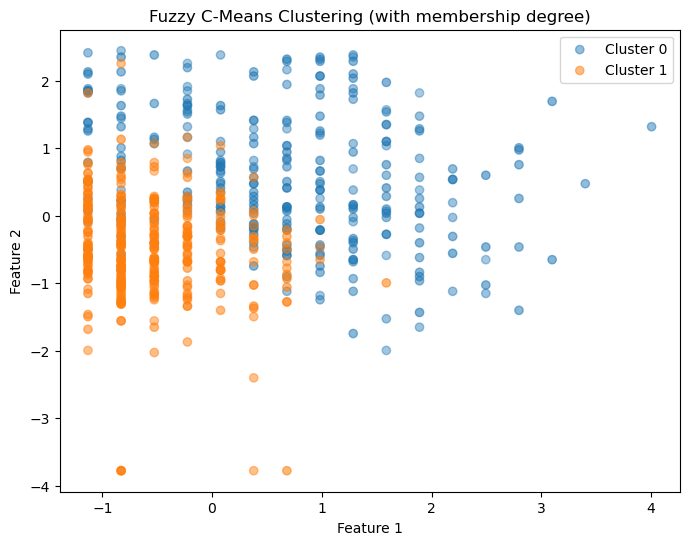

In [342]:
# === CLUSTER VISUALISATION === 

# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0) # Each sample is assigned to the cluster where it has the highest membership degree

# Note: FPC ∈ [0, 1], where:
#   - Values closer to 1 indicate well-defined, distinct clusters
#   - Values closer to 0 indicate poor clustering 
print("Fuzzy partition coefficient (FPC):", fpc)


# --- Plot first two features with fuzzy membership ---
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    # alpha = u[j,:] → transparency reflects membership degree:
    #   - strong membership:  darker color
    #   - weak membership : lighter color
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

#### Plot 1 & FPC Comment 
* This is just slightly above the minimum (1/c = 0.5, for n=2)
* It means the clustering is very fuzzy: samples have almost equal membership in both clusters.
* The algorithm did not find well-separated groups in the data — instead, rules overlap heavily.



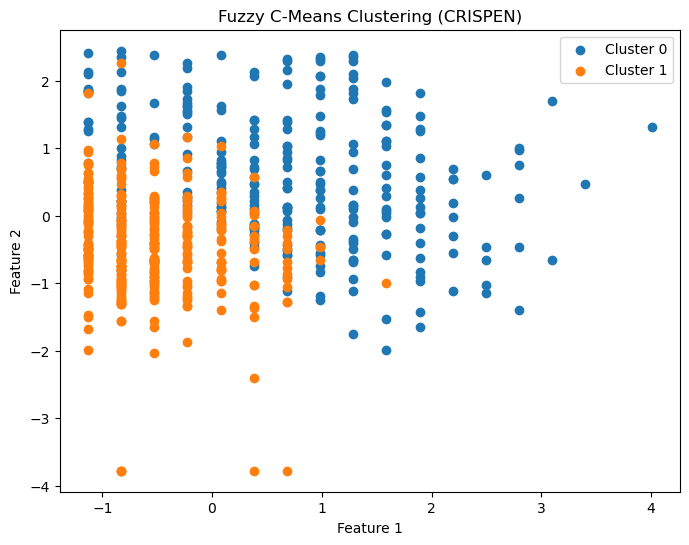

In [343]:
# Plot first two features with cluster assignments (crispened version)
plt.figure(figsize=(8,6))

for j in range(n_clusters):
    # Scatter plot of samples assigned to cluster j (hard clustering).
    # Unlike the previous fuzzy plot, here we ignore membership degrees (alpha),
    # and simply color points by their most likely cluster.
    plt.scatter(
        Xexp[cluster_labels == j, 0],  # Feature 1 
        Xexp[cluster_labels == j, 1],  # Feature 2 
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

#### Plot 2: Results Comment 
As mentioned before, unlike the previous fuzzy plot, here we ignore membership degrees (alpha), and simply color points by their most likely cluster, explaining the absence of color gradients. 

# Gaussian Membership function
#### Inputs:
   - x: input values (vector)
   - mu: mean (center of the Gaussian, from clustering)
   - sigma: standard deviation (spread of the Gaussian, from clustering)
#### Output:
   - degree of membership ∈ [0, 1]

$$
\mu(x) = \exp\left(-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2\right)
$$



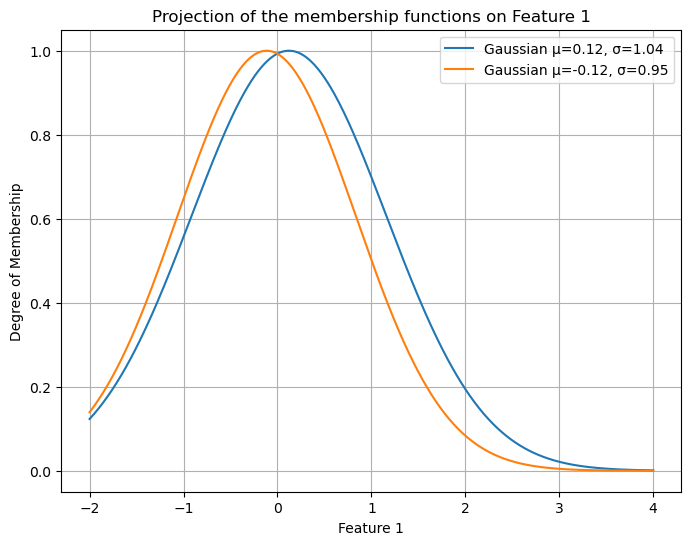

In [344]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

# Generate a range of values for Feature 1 (x-axis of the plot).
# This will let us visualize the Gaussian curves for that feature
lin=np.linspace(-2, 4, 500)

plt.figure(figsize=(8,6))


y_aux=[]
feature=0
for j in range(n_clusters):
    # Compute the Gaussian curve for cluster j on Feature 1.
    # centers[j,0] = mean of cluster j for Feature 1
    # sigmas[j,0] = spread of cluster j for Feature 1
    y_aux.append(gaussian(lin, centers[j,feature], sigmas[j,feature]))

# Plot Gaussian membership 
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,0],2)}, σ={np.round(sigmas[j,0],2)}")

plt.title("Projection of the membership functions on Feature 1")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

#### Plot 2: Results Comment 

* The two means are equal in this case (0.12).
* The spreads (σ ≈ 0.9–1.0) are wide, which is expected because inputs were standardized (σ around 1 ≈ one standard deviation of the original feature).
* On Feature 1, the two rules have strong overlap, so this feature alone doesn’t discriminate the clusters/rules much.

 

In [345]:
# ---------------------------
# Gaussian Membership Function (Antecedents of fuzzy rules)
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        # Each Gaussian MF is defined by its center (μ) and spread (σ).
        # Both are learnable parameters initialized from clustering.
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))

        # Flag for aggregation type:
        # If True: use probabilistic (L2 norm) aggregation
        # If False: use max-distance (equivalent to fuzzy "min" operator)
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting (Broadcasting automatically expands tensors with singleton dimensions (size 1) 
        #so their shapes are compatible for mathematical operations)
        # x: (batch, n_inputs) → (batch, 1, n_inputs)
        # centers: (n_rules, n_inputs) → (1, n_rules, n_inputs)
        # sigmas: (n_rules, n_inputs) → (1, n_rules, n_inputs)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation of distances across input dimensions
        if self.agg_prob:
            # Probabilistic aggregation: smoother intersection across features
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)

        # Final Gaussian membership degree (∈ [0,1])
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)    # Shape: (n_inputs+1, n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Step 1: Compute rule firing strengths via Gaussian MFs
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Step 2: Normalize firing strengths so they sum to 1 for each sample
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Step 3: Compute rule consequents (linear functions of inputs)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias 

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)

        # Step 4: Weighted sum of rule outputs by normalized firing strengths
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        # Return:
        # - output: final prediction
        # - norm_fs: normalized rule activations
        # - rule_outputs: per-rule consequent output
        return output, norm_fs, rule_outputs



In [346]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    # Disable gradient tracking: LS solution is closed-form, no need for backprop
    with torch.no_grad():
        _, norm_fs, _ = model(X) # norm_fs: (n_samples, n_rules)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)

        # Build the design matrix Φ:
        # For each sample, compute input × normalized firing strength per rule
        # einsum: "br" (samples × rules) × "bi" (samples × inputs) → "bri" (samples × rules × inputs)
        # Reshape → (n_samples, (n_rules * (n_inputs+1)))
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        # Using PyTorch's built-in lstsq solver
        theta= torch.linalg.lstsq(Phi, y).solution
    
        # Reshape theta into (n_inputs+1, n_rules) and assign to model parameters
        model.consequents.data = theta.reshape(model.consequents.shape)

    


In [347]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    # Define optimizer: Adam
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Define loss function: Mean Squared Error (MSE) for regression
    criterion = nn.MSELoss()

    # Training Loop
    for _ in range(epochs):
        # Reset accumulated gradients from previous iteration
        optimizer.zero_grad()

        # Forward propagation: predict outputs from the model
        y_pred, _, _ = model(X)

         # Compute loss: mean squared error between predictions and targets
        loss = criterion(y_pred, y)
        print(loss) # to monitor convergence

        # Backward pass: compute gradients of loss of all trainable parameter
        loss.backward()

        # Parameter update: optimizer adjusts centers, sigmas, consequents
        optimizer.step()


In [348]:
# ---------------------------
# Hybrid Training (Classic ANFIS) 
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    """
    Trains an Adaptive Neuro-Fuzzy Inference System (ANFIS) using the hybrid approach:
    - Alternates between Gradient Descent (GD) and Least Squares (LS)
    - GD updates the antecedents (membership function parameters)
    - LS updates the consequents (linear coefficients of fuzzy rules)

    Parameters:
    -----------
    model : ANFIS model instance
    X : torch.Tensor
        Input features.
    y : torch.Tensor
        Target values.
    max_iters : int (default=10)
        Number of hybrid training cycles. 
        Each cycle = one round of GD + LS.
         Larger values → more refinement but higher runtime.
    gd_epochs : int (default=20)
        Number of gradient descent epochs per cycle (for antecedents).
         If max_iters=10 and gd_epochs=20 → total GD epochs = 10*20 = 200.
    lr : float (default=1e-3)
        Learning rate for gradient descent updates.
         Higher values = faster learning but risk of instability (going in the right direction, but the huge steps pass the objective easily) .
    """
    
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

In [349]:
# ---------------------------
# Alternative Hybrid Training (LS+ gradient descent on all)
# ---------------------------
def train_hybrid(model, X, y, epochs=100, lr=1e-4):
    """
    Alternative hybrid training strategy:
    - First fits the consequents with Least Squares (fast, exact solution for linear part).
    - Then applies Gradient Descent to fine-tune *all* parameters (antecedents + consequents).

    Parameters:
    -----------
    model : ANFIS model instance
    X : torch.Tensor
        Input features.
    y : torch.Tensor
        Target values.
    epochs : int (default=100)
        Number of GD iterations for joint fine-tuning.
    lr : float (default=1e-4)
        Learning rate for GD. Typically smaller than in the classic hybrid,
        since all parameters are moving together and training is less stable.
    """
    
    # Step 1: LS for consequents
    train_ls(model, X, y)
    # Step 2: GD fine-tuning
    train_gd(model, X, y, epochs=epochs, lr=lr)


In [350]:
# Build model
model = TSK(n_inputs=Xtr.shape[1],   # number of input features 
            n_rules=n_clusters,      # number of fuzzy rules (from clustering) 
            centers=centers[:,:-1],  # antecedent centers (esclude last col = target)
            sigmas=sigmas[:,:-1]     # antecedent spreads (exclude target dimension)
)

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)


In [351]:
# Training with LS:
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1)) # reshape target y to match tje expected matrix dimensions


tensor(0.1524, grad_fn=<MseLossBackward0>)
tensor(0.1522, grad_fn=<MseLossBackward0>)
tensor(0.1520, grad_fn=<MseLossBackward0>)
tensor(0.1519, grad_fn=<MseLossBackward0>)
tensor(0.1517, grad_fn=<MseLossBackward0>)
tensor(0.1516, grad_fn=<MseLossBackward0>)
tensor(0.1514, grad_fn=<MseLossBackward0>)
tensor(0.1513, grad_fn=<MseLossBackward0>)
tensor(0.1512, grad_fn=<MseLossBackward0>)
tensor(0.1511, grad_fn=<MseLossBackward0>)
tensor(0.1510, grad_fn=<MseLossBackward0>)
tensor(0.1509, grad_fn=<MseLossBackward0>)
tensor(0.1509, grad_fn=<MseLossBackward0>)
tensor(0.1508, grad_fn=<MseLossBackward0>)
tensor(0.1507, grad_fn=<MseLossBackward0>)
tensor(0.1507, grad_fn=<MseLossBackward0>)
tensor(0.1506, grad_fn=<MseLossBackward0>)
tensor(0.1506, grad_fn=<MseLossBackward0>)
tensor(0.1505, grad_fn=<MseLossBackward0>)
tensor(0.1505, grad_fn=<MseLossBackward0>)
tensor(0.1480, grad_fn=<MseLossBackward0>)
tensor(0.1477, grad_fn=<MseLossBackward0>)
tensor(0.1475, grad_fn=<MseLossBackward0>)
tensor(0.14

In [352]:
# ----------------------
# Model Evaluation
#-----------------------

y_pred, _, _=model(Xte)
#performance metric for classification
print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification

#print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

ACC:0.7402597402597403


### ANFIS Binary Classification Result Coments

##### Effect of clusters / m parameter

* Same as in regression: MSE (or classification loss) varies between runs for identical hyperparameters.
* Clusters provide nonlinear decision boundaries, but overlap between membership functions can reduce discriminative power.

##### Effect of learning rate, max_iters, gd_epochs

* Again, trends are harder to isolate brcause of variability.
* Classification task seems slightly more robust to max_iters (i.e., increasing training cycles does not always yield clear improvement).
* Lower learning rates tend to yield smoother convergence, while higher ones increase variance across runs.

# Neural Networks Binary Classification - Dataset 2

In [353]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas

In [354]:
# CHOOSE DATASET

# Regression dataset
#data = datasets.load_diabetes(as_frame=True)

# Binary Classification dataset
data = datasets.fetch_openml(name="diabetes",version=1, as_frame=True) 

X = data.data.values     # Feature Assignement to variable X: (768 samples, 8 features)
y = data.target.values   # target assignment to varible Y: (768 samples, binary outcome: 0 = no diabetes, 1 = diabetes)

print(X.shape)    # Check dimensions X: should be (768, 8)
print(y.shape)    # Check dimensions Y: should be (768, ) - 1D array in numpy 

(768, 8)
(768,)


In [355]:
# Visualising first 5 rows of Dataset 2
data.data.head(5)

,preg,plas,pres,skin,insu,mass,pedi,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [356]:
# Make sure y is numeric (0 = negative, 1 = positive)
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)

#train test spliting
test_size=0.2 # 20 % of data will be reserved for testing (or dev more apropriatly),and 80 % for training 
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

# Note: for comparisons is important to mantain both the train/test split and the seed (random_state) equal across models

In [357]:
# Standardize features
# Note: standardization ensures that all input variables contribute equally 
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

In [358]:
# ---------------------------
# Multi-Layer Perceptron (MLP) with Dropout Regularization
# ---------------------------
class MLP(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.1):
        super(MLP, self).__init__()

        
        # Fully connected layers (deep feedforward network with 4 hidden layers)
        # - Each hidden layer has 64 neurons
        # - The last layer maps to the output dimension (default = regression, output_size=1)
        self.fc1 = nn.Linear(input_size, 64)  # input -> hidden1
        self.fc2 = nn.Linear(64, 64)          # hidden1 -> hidden2
        self.fc3 = nn.Linear(64, 64)          # hidden2 -> hidden3
        self.fc4 = nn.Linear(64, 64)          # hidden3 -> hidden4       
        self.out = nn.Linear(64, output_size) # hidden4 -> output

        # Dropout layer (randomly "drops" neurons during training to prevent overfitting)
        # - p = dropout probability (default = 0.5 -> 50% of neurons are "turned off")
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        """
        Defines the forward pass through the network.
        Each hidden layer uses ReLU activation + dropout for regularization.
        """

        # Layer 1: Fully connected -> ReLU -> Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Layer 2: Fully connected -> ReLU -> Dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Layer 3: Fully connected -> ReLU -> Dropout
        x = F.relu(self.fc3(x))
        x = self.dropout(x)

        # Layer 4: Fully connected -> ReLU -> Dropout
        x = F.relu(self.fc4(x))
        x = self.dropout(x)

        # Output layer (no activation, since this can be regression or classification depending on usage)
        x = self.out(x)
        return x

In [359]:
# Hyperparameters
num_epochs = 100    # number of full passes through the training dataset
lr = 0.0004         # learning rate (step size for optimizer updates; smaller -> slower but more stable)
dropout = 0.1       # dropout probability (10% of neurons are dropped during training for regularization)
batch_size = 64     # number of samples per training batch (trade-off: memory vs. training stability/speed)

In [360]:
Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

# Wrap Xtr and ytr into a dataset
train_dataset = TensorDataset(Xtr, ytr)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [361]:
# ---------------------------
# Model, Loss, Optimizer
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_size=Xtr.shape[1], dropout_prob=dropout).to(device)

# Loss function:
# - Use BCEWithLogitsLoss for binary classification (includes sigmoid internally)
criterion = nn.BCEWithLogitsLoss()  # for binary classification

optimizer = optim.Adam(model.parameters(), lr=lr)

In [362]:
# ---------------------------
# Training Loop
# ---------------------------
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0      # running loss for this epoch

    # Iterate through batches of training data
    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # Forward pass: compute predictions (logits = raw model outputs)
        logits = model(batch_x) # compute gradients with model parameters
        
        # Compute loss
        # - .view(-1, 1) reshapes y to match (batch_size, 1) output format
        loss = criterion(logits, batch_y.view(-1, 1))
        
        # Backward pass: compute gradients
        optimizer.zero_grad() # reset gradients (otherwise they accumulate)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/100], Loss: 0.6759
Epoch [2/100], Loss: 0.6680
Epoch [3/100], Loss: 0.6542
Epoch [4/100], Loss: 0.6433
Epoch [5/100], Loss: 0.6226
Epoch [6/100], Loss: 0.5984
Epoch [7/100], Loss: 0.5706
Epoch [8/100], Loss: 0.5407
Epoch [9/100], Loss: 0.5116
Epoch [10/100], Loss: 0.4992
Epoch [11/100], Loss: 0.4812
Epoch [12/100], Loss: 0.4607
Epoch [13/100], Loss: 0.4670
Epoch [14/100], Loss: 0.4576
Epoch [15/100], Loss: 0.4692
Epoch [16/100], Loss: 0.4506
Epoch [17/100], Loss: 0.4463
Epoch [18/100], Loss: 0.4570
Epoch [19/100], Loss: 0.4514
Epoch [20/100], Loss: 0.4368
Epoch [21/100], Loss: 0.4243
Epoch [22/100], Loss: 0.4439
Epoch [23/100], Loss: 0.4363
Epoch [24/100], Loss: 0.4286
Epoch [25/100], Loss: 0.4295
Epoch [26/100], Loss: 0.4276
Epoch [27/100], Loss: 0.4328
Epoch [28/100], Loss: 0.4339
Epoch [29/100], Loss: 0.4279
Epoch [30/100], Loss: 0.4118
Epoch [31/100], Loss: 0.4149
Epoch [32/100], Loss: 0.4192
Epoch [33/100], Loss: 0.4220
Epoch [34/100], Loss: 0.4215
Epoch [35/100], Loss: 0

In [363]:
y_pred=model(Xte)
print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification


ACC:0.7467532467532467


### NN Regression Result Comments 
###### NN Architecture & Modifications

* The chosen architecture is a deep feedforward MLP with 4 hidden layers (64 neurons each, ReLU activations).
* Dropout was applied after each hidden layer as a regularization technique.
* The output layer for regression: linear output with MSE loss.

###### Potential modifications and expected effects:

* More hidden layers / more neurons per layer → increases model capacity, allowing it to capture more complex relationships, but also increases risk of overfitting and training instability.
* Fewer layers / smaller hidden size → simpler model, faster training, but may underfit if the data is highly nonlinear.
* Different activation functions (e.g., Leaky ReLU, Tanh) → could affect gradient flow and learning dynamics.
* Batch Normalization → could stabilize training and reduce sensitivity to learning rate.


###### Dropout Variability

* Dropout introduces stochasticity during training (different neurons are dropped at each pass), so results naturally vary between runs.
* Lower dropout (e.g. 0.1) → keeps more neurons active, risk of overfitting but more stable convergence. 
* The best values were until 0.2 really 
* Higher dropout (e.g. 0.5) → stronger regularization, reduces overfitting but increases run-to-run variability and slows learning.
* This explains why even with the same hyperparameters, loss/accuracy curves differ slightly across runs.


###### Hyperparameters (FOR optimizers like Adam)

* Learning Rate (lr):
* Small lr (e.g. 1e-5) → slow convergence, model may look underfitted if training stops early.
* Large lr (e.g. 1e-2) → unstable training, loss oscillates or diverges.
* Moderate values (e.g. 5e-4 or 1e-3) gave the best trade-off between stability and speed.
NOTE: For deeper NN the best values should be even smaller 

###### Batch size:

* 64 worked well as a balance between convergence stability and GPU efficiency.
* Larger batch sizes (128–256) can smooth gradients but may require tuning lr.

###### Epochs:

* More epochs -> more chances to converge, but diminishing returns if the model is already fitting well.
* Early stopping (based on validation loss) would be a good addition here.

###### Dataset 2 (Binary Classification)

* For classification, the NN benefits from dropout more than in regression (since overfitting on class boundaries is common).
* However, dropout makes results noisier — accuracy can swing between runs with identical settings.
* Lower dropout or ensembling multiple runs could stabilize results.

# Comparison Bettween the Models:

#### Classification problem (Dataset 2):

* The NN achieved slightly better performance than ANFIS.
* This is expected since deep networks are very effective at learning nonlinear class boundaries and benefit from dropout regularization.
* ANFIS, while interpretable, struggled with overlapping membership functions, which limited its discriminative power.

#### Regression problem (Dataset 1):

* ANFIS appeared to perform better than the NN.
* The fuzzy rule structure allowed it to approximate the underlying function more directly.
* The NN also convwrged, but its results were less precise compared to ANFIS in this case.

#### General takeaway:

* NNs tend to be more robust and stable across runs, particularly in classification tasks, but sacrifice interpretability.
* ANFIS shows competitive (and sometimes superior) results in regression, and has the advantage of rule-based interpretability, though it suffers from variability in training outcomes. 
* The choice between the two depends on the task: if accuracy and stability are the priority, NN is a safer choice; if interpretability is critical, ANFIS offers more transparency.

-

-

- 